In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, f1_score, accuracy_score, silhouette_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [185]:
merged_data = pd.read_csv('../data/merged_df.csv')

#Convert class licit to be 0 and illicit to be 1 and leave unknown as unknown 
merged_data['class'] = merged_data['class'].map({'licit': 0, 'illicit': 1, 'unknown': 'unknown'})

In [186]:
# Remove all unknown class
merged_data = merged_data[merged_data['class'] != 'unknown']

In [204]:
merged_data

,txId,Time step,local_feature_0,local_feature_1,local_feature_2,local_feature_3,local_feature_4,local_feature_5,local_feature_6,local_feature_7,...,aggregate_feature_63,aggregate_feature_64,aggregate_feature_65,aggregate_feature_66,aggregate_feature_67,aggregate_feature_68,aggregate_feature_69,aggregate_feature_70,aggregate_feature_71,class
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
9,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,0
10,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
11,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
16,3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,...,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203752,80329479,49,-0.159293,-0.037276,1.018602,-0.121970,0.035526,-0.113002,-0.061584,-0.149635,...,1.408971,0.231244,-0.388216,-0.098889,1.931078,3.168259,3.707301,-1.390548,-1.214035,0
203754,158406298,49,-0.172962,-0.126566,1.018602,-0.121970,-0.063725,-0.113002,-0.061584,-0.163622,...,0.647874,0.241128,0.241406,10.914916,1.700384,-0.131155,7.914145,-0.120613,-0.119792,0
203759,158375075,49,-0.170412,-0.078164,1.018602,0.028105,-0.043875,0.054722,-0.061584,-0.163631,...,1.606604,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1
203763,147478192,49,-0.093732,-0.116160,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.082559,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0


In [187]:
# Create X and y from the merged data
X = merged_data.drop(columns=['txId', 'Time step', 'class'])
y = merged_data['class']

In [188]:
# Create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [189]:
y_train, y_test = y_train.astype('int'), y_test.astype('int')

In [190]:
# Create an array to hold the model accuracy which includes prec, rec, f1, and micro_f1, accuracy and model name to compare later
model_accuracy = []

In [191]:
# Create a function to plot the confusion matrix
def plot_confusion_matrix(y_test, y_pred, model_name):   
    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix: ' + model_name, size=15)
    plt.show()

# Create a function to calculate the model accuracy
def model_accuracy_calc(model, model_name):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate the precision, recall, f1 and support
    prec, rec, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)
    
    # Calculate the micro f1 score
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    
    # Calculate the accuracy
    acc = model.score(X_test, y_test)

    plot_confusion_matrix(y_test, y_pred, model_name)
    
    # Append the model accuracy to the model_accuracy array
    model_accuracy.append([model_name, prec[1], rec[1], f1[1], micro_f1, acc])

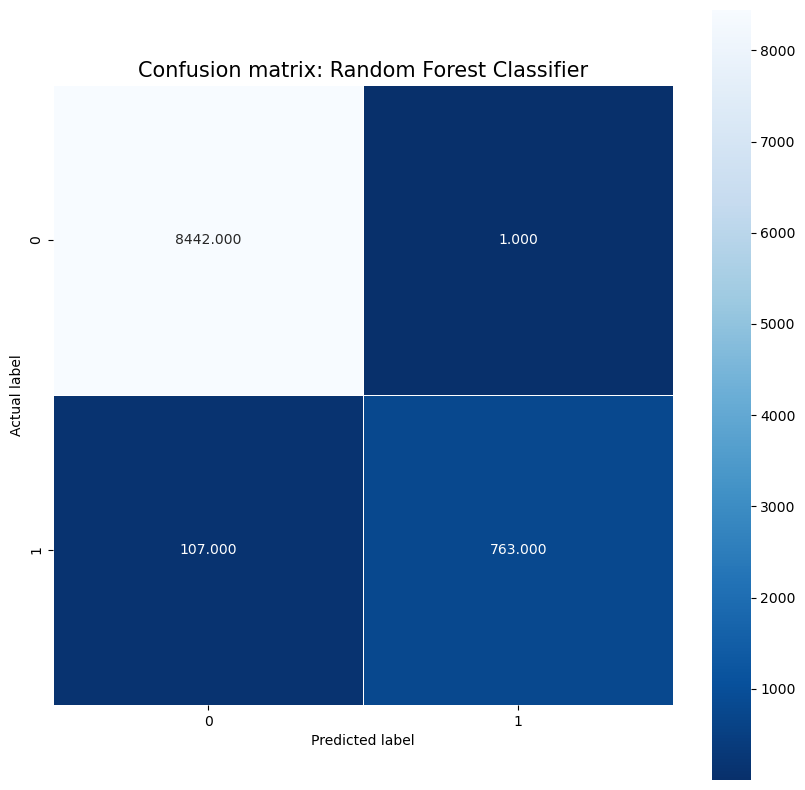

In [192]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=43)
model_accuracy_calc(rfc, 'Random Forest Classifier')

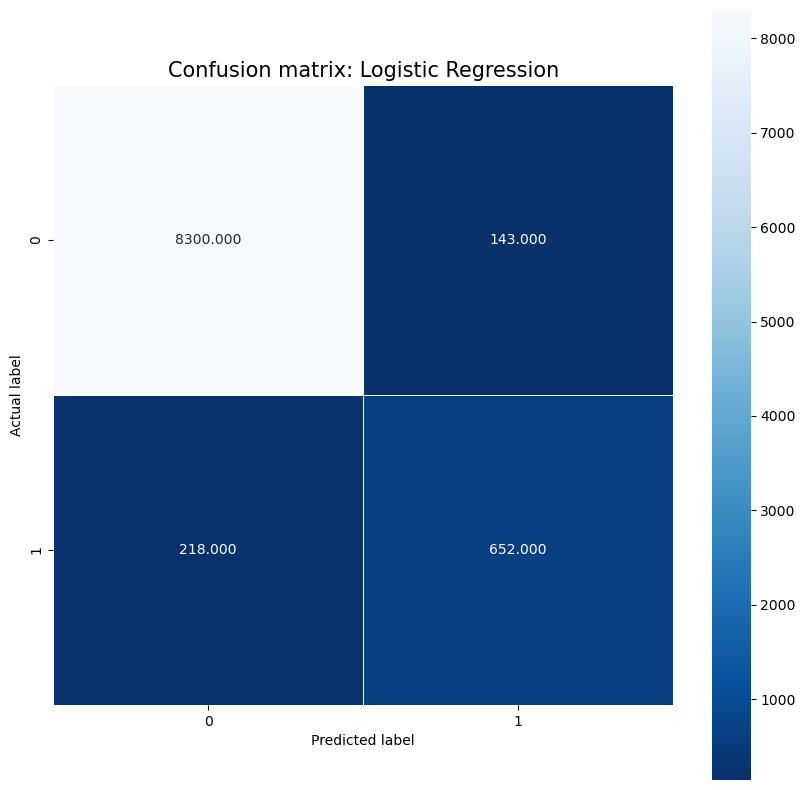

In [193]:
# Logistic Regression
lr = LogisticRegression(random_state=43, max_iter=1000)
model_accuracy_calc(lr, 'Logistic Regression')

c:\Users\Vincent\anaconda3\envs\MastercardEnvironment\Lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\Vincent\anaconda3\envs\MastercardEnvironment\Lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
c:\Users\Vincent\anaconda3\envs\MastercardEnvironment\Lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


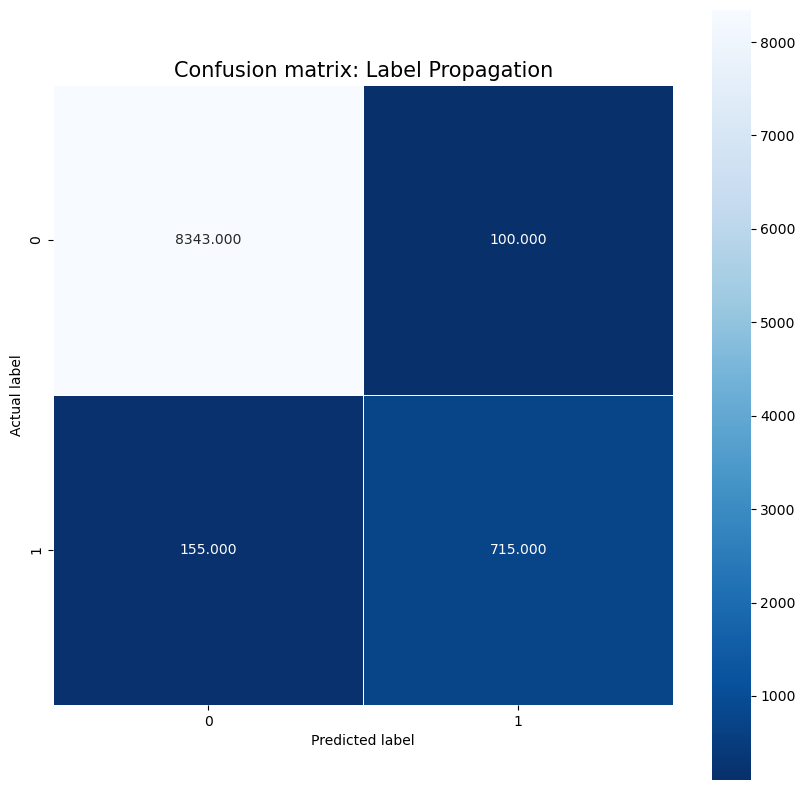

In [194]:
# Sklearn semi supervised learning
# Label Propagation
lp = LabelPropagation()
model_accuracy_calc(lp, 'Label Propagation')


c:\Users\Vincent\anaconda3\envs\MastercardEnvironment\Lib\site-packages\sklearn\utils\extmath.py:193: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\Vincent\anaconda3\envs\MastercardEnvironment\Lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
c:\Users\Vincent\anaconda3\envs\MastercardEnvironment\Lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


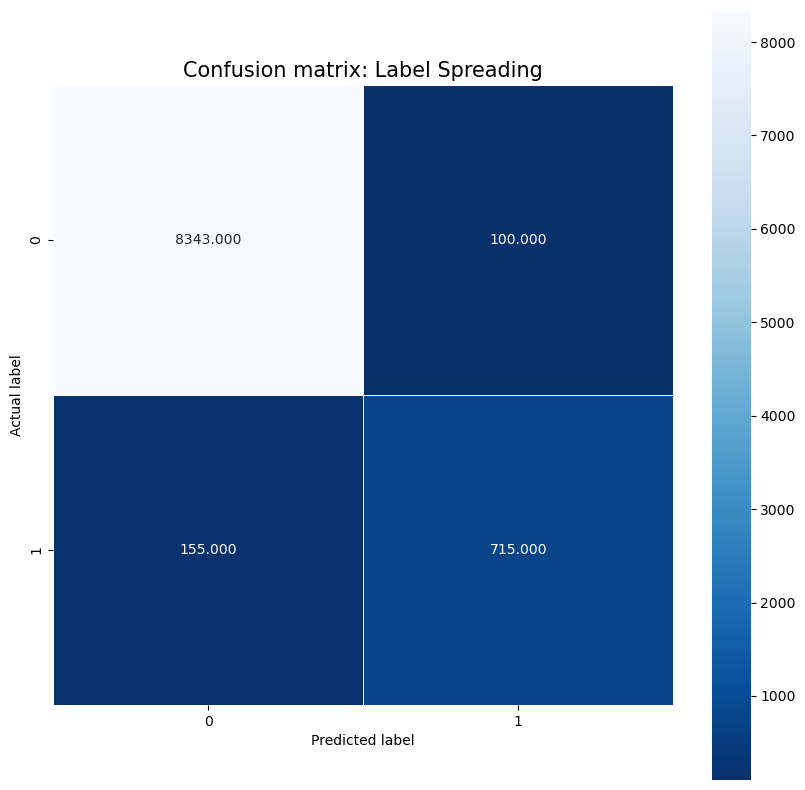

In [195]:
# Label Spreading
ls = LabelSpreading()
model_accuracy_calc(ls, 'Label Spreading')

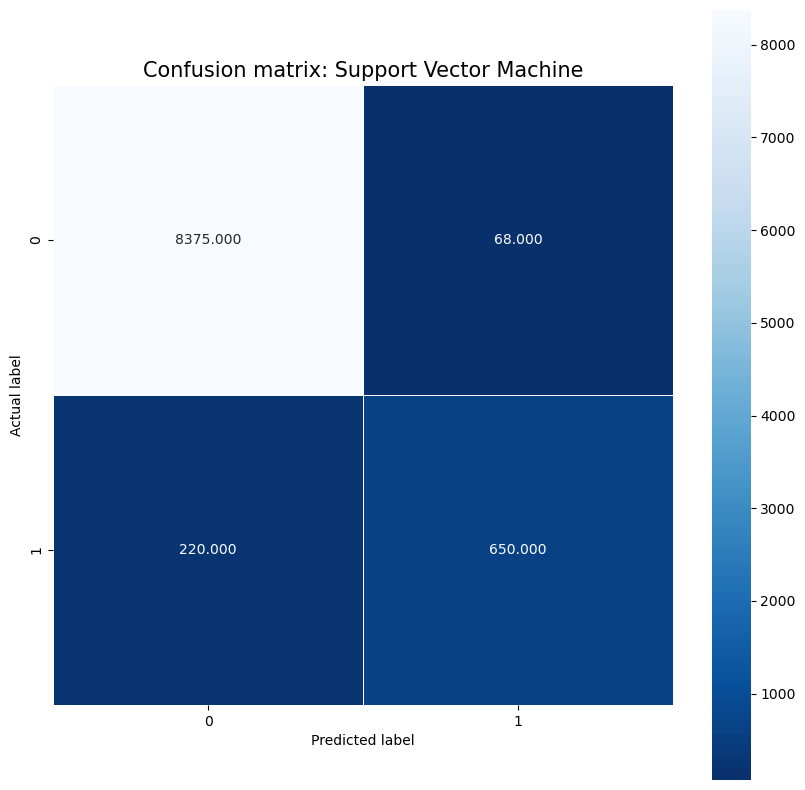

In [196]:
# Support Vector Machine
svc = SVC()
model_accuracy_calc(svc, 'Support Vector Machine')

In [197]:
model_accuracy_df = pd.DataFrame(model_accuracy, columns=['Model','Precision', 'Recall', 'F1', 'Micro F1', 'Accuracy'])

In [198]:
model_accuracy_df

,Model,Precision,Recall,F1,Micro F1,Accuracy
0,Random Forest Classifier,0.998691,0.877011,0.933905,0.988403,0.988403
1,Logistic Regression,0.820126,0.749425,0.783183,0.961237,0.961237
2,Label Propagation,0.877301,0.821839,0.848665,0.972619,0.972619
3,Label Spreading,0.877301,0.821839,0.848665,0.972619,0.972619
4,Support Vector Machine,0.905292,0.747126,0.818640,0.969075,0.969075


# Graph and comparison of sklearn supervised and semi-supervised methods

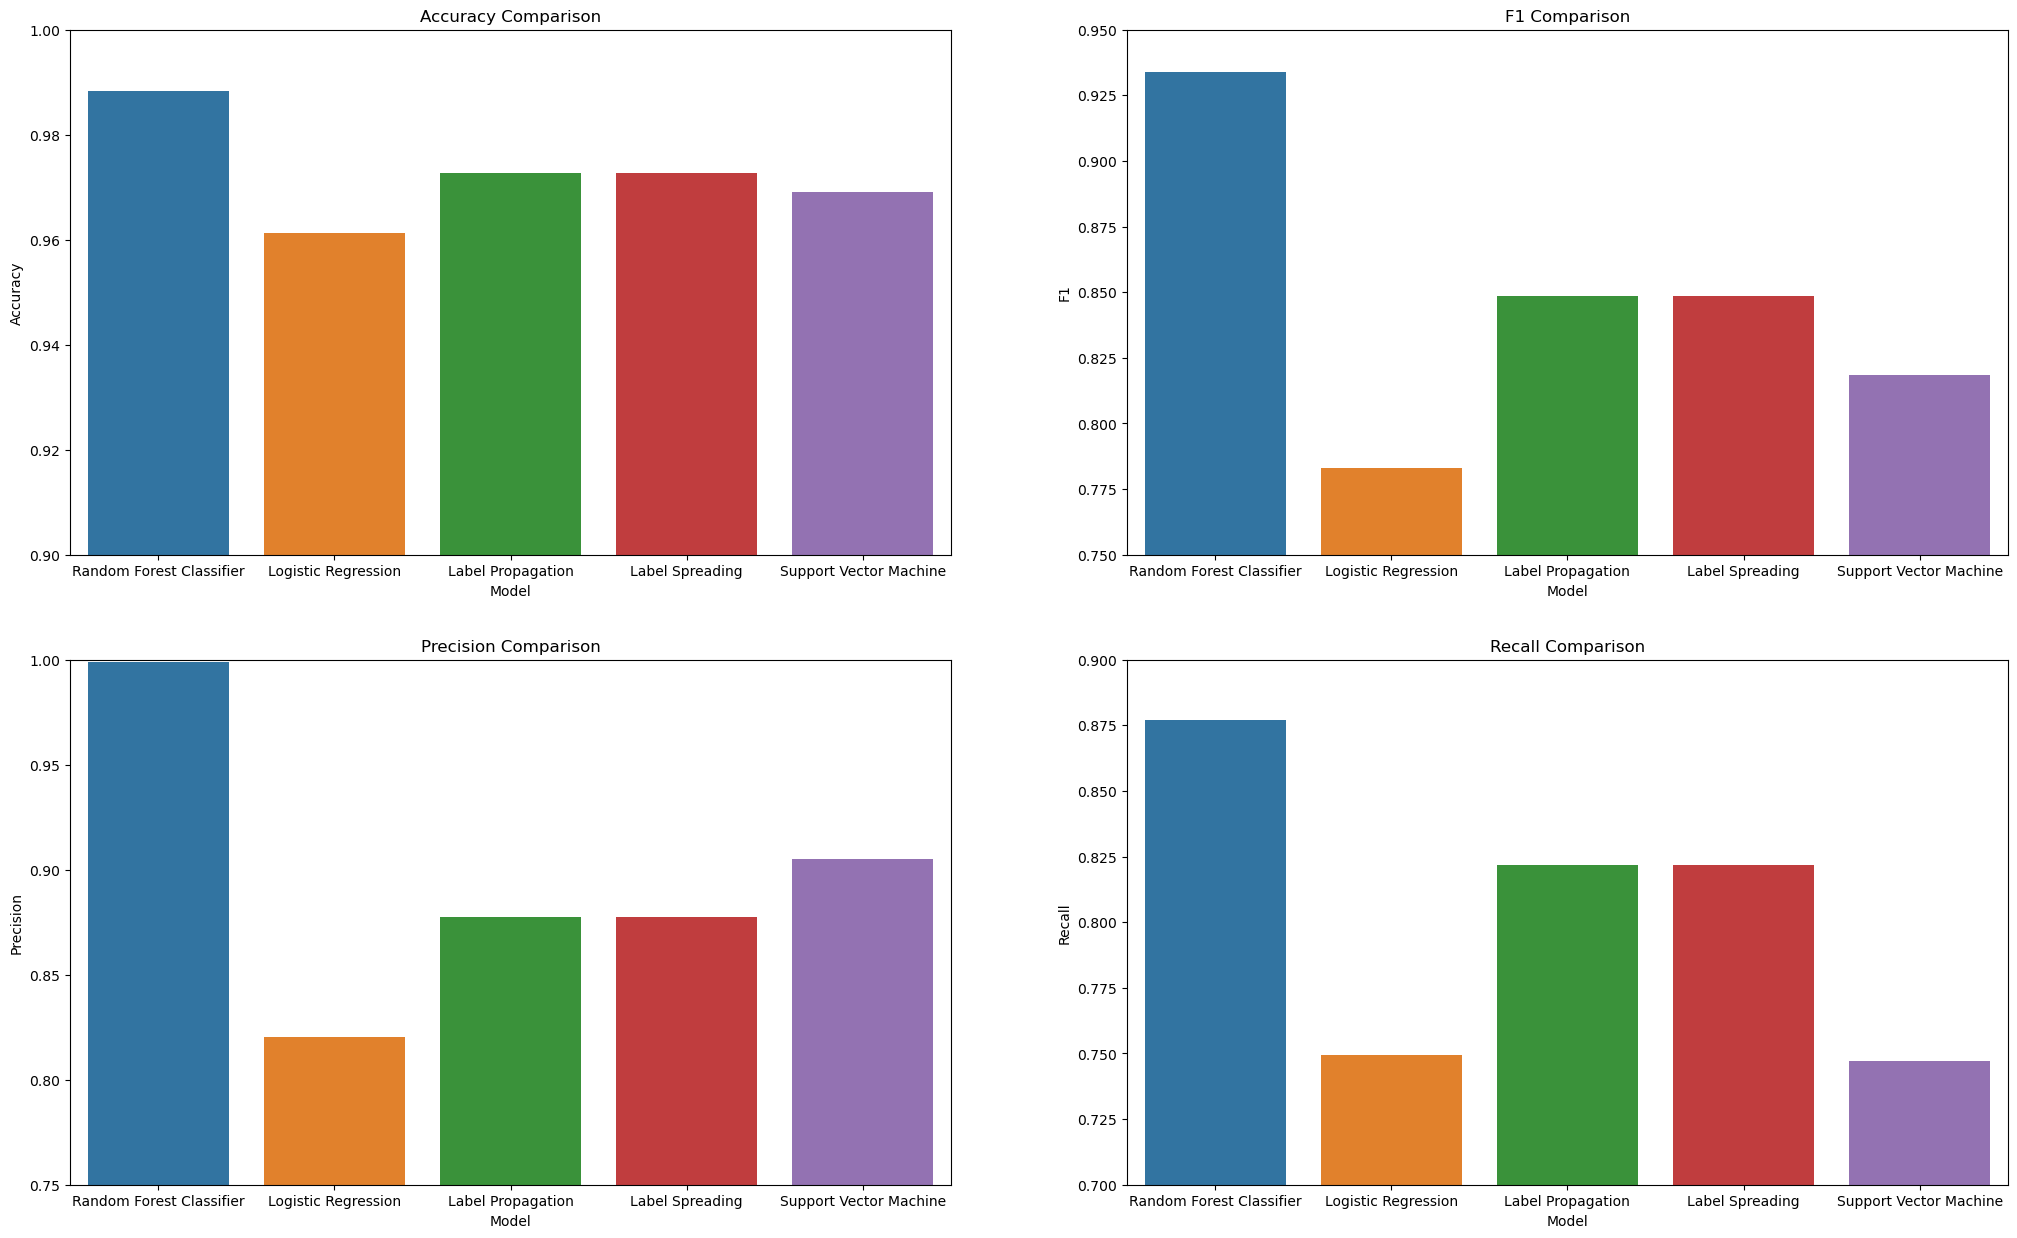

In [199]:
# Bar plot the models with accuracy and f1 for comparison
plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.ylim(0.9, 1)
sns.barplot(x='Model', y='Accuracy', data=model_accuracy_df)
plt.title('Accuracy Comparison')
plt.subplot(2, 2, 2)
plt.ylim(0.75, 0.95)
sns.barplot(x='Model', y='F1', data=model_accuracy_df)
plt.title('F1 Comparison')
plt.subplot(2, 2, 3)
plt.ylim(0.75, 1)
sns.barplot(x='Model', y='Precision', data=model_accuracy_df)
plt.title('Precision Comparison')
plt.subplot(2, 2, 4)
plt.ylim(0.7, 0.9)
sns.barplot(x='Model', y='Recall', data=model_accuracy_df)
plt.title('Recall Comparison')
plt.show()


# Evaluating how many clusters for kmeans

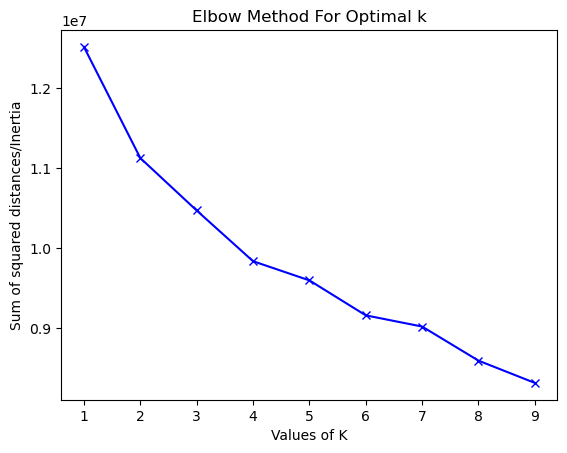

In [200]:
# Elbow method to find the optimal k

Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters, n_init=10, max_iter=1000)
 kmeans.fit(X_train)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

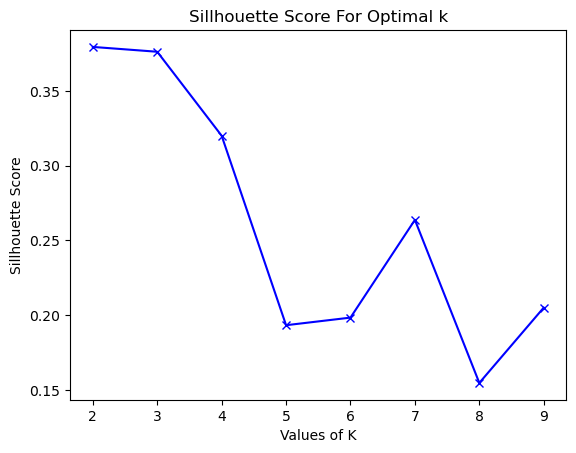

In [203]:
# Sillhouette score to find the optimal k

sillhouette_avg = []
K = range(2,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, max_iter=1000)
    kmeans.fit(X_train)
    cluster_labels = kmeans.labels_
    # silhouette score
    sillhouette_avg.append(silhouette_score(X_train, cluster_labels))
plt.plot(K, sillhouette_avg, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sillhouette Score') 
plt.title('Sillhouette Score For Optimal k')
plt.show()

In [202]:
# Kmeans clustering
kmeans = KMeans(n_clusters=2, random_state=43, n_init=10, max_iter=1000)
kmeans.fit_predict(X_train, y_train)
y_pred = kmeans.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', accuracy)

Accuracy:  0.7596907548587996
